# Lasso via ADMM

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as spla

## Utility Functions

In [11]:
def soft_thresh(x, threshold):
    """Soft threshold function

    Inputs:
    x : variable
    threshold: scalar
    """

    return np.sign(x) * np.maximum(np.absolute(x) - threshold, np.zeros(np.shape(x)))

def calc_obj(X,y,beta, z, lam):
    """Normalized MSE + l_1 regularization for ADMM (two decision vectors!)""" 

    return (1 / np.shape(X)[0]) * (np.linalg.norm(y - np.dot(X, beta)))**2 + lam * np.sum(np.abs(z))

def admm(X, y, beta ,lam = 0.0001, tol = 1e-3, rho = 1):
    """
    Solve lasso with ADMM. Following the formulation of Boyd 2011 review paper.
    
    Inputs:
    X: feature matrix
    y: labels
    beta: variables
    g: Parameter of lasso
    tol: tolerance
    rho: ADMM parameter
    """

    last_obj = float('inf')
    obj_change = float('inf')
    costs = []

    # cache some matrices
    XTX = np.dot(X.T, X)
    inv_mtx = XTX + rho * np.identity(np.shape(X)[1])
    lu_mtx = spla.lu_factor(inv_mtx)
    
    XTy = np.dot(X.T, y)

    costs = []
    z = np.copy(beta)
    u = np.zeros(beta.shape) #initialize to zero
    

    while obj_change > tol:
        
        # solve for beta (x in original formulation)
        right_mtx = XTy + rho * (z - u)
        beta = spla.lu_solve(lu_mtx, right_mtx)
        
        # update z and u
        z = soft_thresh(beta + u, lam/rho)
        u = u + beta - z

        current_obj = calc_obj(X,y,beta, z, lam)
        obj_change = abs(current_obj - last_obj)
        last_obj = current_obj
        costs.append(current_obj)

    return beta, costs

## Read data and perform optimization

In [12]:
X = pd.read_csv('diabetesX.csv')
y = pd.read_csv('diabetesY.csv',header=None)

# Add a column of 0.01's for the intercept. Chose 0.01 to be in a similar scale with other features
X['ones'] = 0.01* np.ones((X.shape[0],1))

X = X.values
y = y.values

beta = np.random.rand(X.shape[1],1) 


beta, costs = admm(X,y,beta)

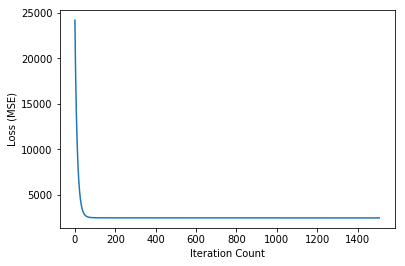

2433.82004218


In [14]:
plt.plot(costs, label = 'ADMM')
plt.ylabel('Loss (MSE)')
#plt.yscale('log')
plt.xlabel('Iteration Count')
plt.show()

print(costs[-1])

## Results

The above figure shows how the loss function decreases as we perform more iterations. The minimum in-sample MSE we get from proximal gradient descent is 2435. This is very close to the optimal in-sample MSE obtained by the scikit-learn package (described in detail in [this notebook](https://github.com/bowenhua/SDS_385/blob/master/5_sparsity/lasso_CV.ipynb)), as well as the optimal in-sample MSE obtained by proximal gradient method (described in detail in [this notebook](https://github.com/bowenhua/SDS_385/blob/master/6_proximal_gradient/Proximal%20gradient%20method.ipynb)).

We also note that the convergence of ADMM seems to be faster than proximal gradient method for this problem.